# Financial Services Client Segmentation & Persona Analysis

This notebook implements a **complete clustering pipeline** for **banking clients segmentation** using the **K-Medoids algorithm**. In this project, we aim to understand the diverse needs of a client base and tailor financial services accordingly. Below is an overview of the analysis:

---

## **Project Overview**

- **Objective:**  
  To segment our bank clients into distinct clusters and develop targeted personas that help us design customized financial products and services.

- **Data Source:**  
  The analysis is based on a dataset of bank clients ("*Dataset1_BankClients.xlsx*")"containing both numerical and categorical features such as age, family size, income, wealth, debt, financial education, digital adoption, and more. Metadata is used to interpret these features and their corresponding scales.

- **Preprocessing Steps:**  
  - **Winsorization:** Applied to numerical features to reduce the impact of outliers.
  - **Standard Scaling:** Normalizes numerical features.
  - **Dimensionality Reduction:** PCA is used to reduce the complexity of numerical data.
  - **One-Hot Encoding:** Transforms categorical features, with careful handling of dropped dummy variables.

- **Distance Metrics & Clustering:**  
  - Multiple distance metrics (e.g., Gower, Euclidean, Manhattan, Cosine, Chebyshev, and custom hybrid metrics) are computed.
  - K-Medoids clustering is performed across different values of *k* to identify optimal clusters.
  - Clustering performance is evaluated using metrics such as Calinski-Harabasz, Davies-Bouldin, Silhouette, Dunn, and WCSS.

- **Persona Development:**  
  Based on the clustering results, three key personas have been identified:
  1. **Urban High-Earner:** Younger, high-income, digitally savvy professionals residing in large cities.
  2. **Retired Traditionalists:** Older, predominantly retired individuals with low digital adoption, preferring personalized, in-branch services.
  3. **Midlife Moderates:** Clients in their mid-fifties with balanced financial profiles, moderate digital adoption, and a preference for hybrid service models.

- **Service Model Recommendations:**  
  Each persona is matched with a tailored service model that outlines optimal channels (digital, physical, or hybrid) and product offerings designed to meet their unique financial needs.

# Required Dependencies

This notebook requires the following Python libraries to be installed:

- **pandas**: For data manipulation and analysis.
- **numpy**: For numerical computations.
- **seaborn**: For statistical data visualization.
- **matplotlib**: For plotting and visualization.
- **scikit-learn**: For machine learning tools (e.g., PCA, t-SNE, clustering metrics).
- **scikit-learn-extra**: Provides the KMedoids clustering algorithm.
- **plotly**: For interactive data visualizations.
- **gower**: For computing Gower distance for mixed data types.
- **IPython**: For enhanced interactive functionality (e.g., display).
- **scipy**: For scientific computing (used in distance computations).
- **jupyter**: To run the notebook.
- **openpyxl**: For reading Excel files with pandas.

## Installation

To install all the required libraries, open your terminal or command prompt, activate your virtual environment (if necessary), and run the following command:

```bash
pip install pandas numpy seaborn matplotlib scikit-learn scikit-learn-extra plotly gower ipython scipy jupyter openpyxl

# Data Loading and Initial Cleaning

In this section, we import the necessary libraries and load the bank clients dataset from an Excel file. We then perform an initial cleaning step by dropping the `ID` column if it is present, since it is not needed for the analysis. Finally, we display the first 5 rows of the cleaned dataset to verify that the data has been loaded correctly.

In [ ]:
import pandas as pd
import numpy as np

# Load dataset (Update path if necessary)
path = 'Dataset1_BankClients.xlsx'
data = pd.read_excel(path)

# Drop ID column if present
if 'ID' in data.columns:
    df = data.drop(columns=['ID'])

# Display first 5 rows
df.head()


,Age,Gender,Job,Area,CitySize,FamilySize,Income,Wealth,Debt,FinEdu,ESG,Digital,BankFriend,LifeStyle,Luxury,Saving,Investments
0,24,1,1,2,2,4,0.668046,0.702786,0.262070,0.741853,0.483684,0.698625,0.618259,0.607877,0.897369,0.283222,1
1,47,1,2,2,3,1,0.858453,0.915043,0.730430,0.859423,0.537167,0.959025,0.785936,0.862271,0.913729,0.821590,3
2,38,0,2,1,2,2,0.926818,0.898316,0.441272,0.485953,0.649434,0.750265,0.699725,0.755404,0.765199,0.503790,3
3,67,0,2,1,2,3,0.538797,0.423180,0.600401,0.493144,0.533829,0.590165,0.675353,0.334432,0.517209,0.691240,2
4,33,0,2,1,3,1,0.806659,0.731404,0.831449,0.856286,0.784940,0.710026,0.758793,0.908878,0.611610,0.615916,2


# Data Preparation, Transformation & Feature Engineering

This section performs a comprehensive preprocessing pipeline to prepare the data for clustering and further analysis. The main steps include:

1. **Data Preparation:**
   - Create a working copy of the loaded dataset.
   - Define the categorical columns (`Gender`, `Job`, `Area`, `CitySize`, `Investments`) and identify the numerical columns.
   - Separate the dataset into numerical and categorical features.

2. **Winsorization & Correlation-Based Feature Reduction:**
   - Apply winsorization to numerical features (clipping extreme values at the 1% tails) to reduce the impact of outliers.
   - Compute the correlation matrix and use the upper triangle to identify and drop highly correlated features (correlation > 0.85).

3. **Feature Scaling & PCA for Numerical Features:**
   - Scale the reduced numerical features using `StandardScaler` and save the scaler for later inverse transformations.
   - Perform Principal Component Analysis (PCA) to reduce dimensionality.
   - Plot cumulative explained variance to determine the number of components required to explain at least 90% of the variance.
   - Save the PCA transformation object for later use.

4. **One-Hot Encoding for Categorical Features:**
   - Transform the categorical features using `OneHotEncoder` (dropping the first category to avoid multicollinearity) with `handle_unknown='ignore'` and `sparse_output=False`.

5. **Combining Transformed Features:**
   - Concatenate the PCA-transformed numerical features and the one-hot encoded categorical features.
   - Verify that the number of columns matches the expected count and create a DataFrame with appropriate column names.

6. **Additional Feature Processing:**
   - Process extra numerical features (for professional profiling and fine-education) using separate scalers to allow for future inverse transformations.

7. **Saving Transformation Objects:**
   - Save key transformation objects (`scaler_num`, `pca_obj`, `encoder`, `scaler_prof`, and `scaler_finedu`) for inverse transformation and reconstruction of the original features.

This pipeline ensures that the dataset is properly cleaned, scaled, and transformed, laying a solid foundation for subsequent clustering and analysis.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from scipy.stats.mstats import winsorize

# -------------------------
# 1. Data Preparation
# -------------------------
# Create a working copy of the original dataset.
df_cleaned = df.copy()

# Define categorical columns and extract numerical columns (excluding categorical ones).
categorical_columns = ['Gender', 'Job', 'Area', 'CitySize', 'Investments']
numerical_columns = df_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_columns = [col for col in numerical_columns if col not in categorical_columns]

# Separate the dataset into numerical and categorical features.
numerical_features = df_cleaned[numerical_columns].copy()
categorical_features = df_cleaned[categorical_columns].copy()

# -------------------------
# 2. Winsorization & Correlation-Based Feature Reduction
# -------------------------
# Apply winsorization: clip extreme values (top and bottom 1%) for each numerical feature.
for col in numerical_features.columns:
    numerical_features[col] = winsorize(numerical_features[col], limits=[0.01, 0.01])

# Compute the absolute correlation matrix.
corr_matrix = numerical_features.corr().abs()
# Extract the upper triangle of the correlation matrix.
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Identify features with correlation > 0.85.
features_to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]
print(f"Features dropped due to high correlation: {features_to_drop}")

# Drop the highly correlated features.
numerical_features_reduced = numerical_features.drop(columns=features_to_drop)

# -------------------------
# 3. Feature Scaling & PCA (for Numerical Features)
# -------------------------
plt.figure(figsize=(10, 5))
sns.boxplot(data=numerical_features)
plt.xticks(rotation=45)
plt.title("Numerical Variables")
plt.show()

# Scale the reduced numerical features.
scaler_num = StandardScaler()
X_num_scaled_reduced = scaler_num.fit_transform(numerical_features_reduced)

plt.figure(figsize=(10, 5))
sns.boxplot(data=X_num_scaled_reduced)
plt.xticks(rotation=45)
plt.title("Numerical Variables Normalized")
plt.show()

# Perform PCA on the scaled data.
# Fit PCA on all components to check cumulative explained variance.
pca_full = PCA()
pca_full.fit(X_num_scaled_reduced)
explained_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Determine the minimum number of components needed for >= 90% variance.
optimal_components = np.argmax(explained_variance >= 0.90) + 1
print(f"Optimal number of PCA components to retain ≥90% variance: {optimal_components}")

# Fit PCA with the optimal number of components.
pca_obj = PCA(n_components=optimal_components)
X_pca = pca_obj.fit_transform(X_num_scaled_reduced)

# -------------------------
# Enhanced PCA Explained Variance Plot
# -------------------------
plt.figure(figsize=(10, 6), dpi=300)  # Increase DPI for higher resolution
components = np.arange(1, len(explained_variance) + 1)
# Bar plot for individual explained variance ratios.
plt.bar(components, pca_full.explained_variance_ratio_[:len(components)], 
        alpha=0.6, color='skyblue', label='Explained Variance Ratio')
# Line plot for cumulative explained variance.
plt.plot(components, explained_variance, marker='o', color='red', label='Cumulative Explained Variance')
# Add text annotations for cumulative variance percentages.
for i, cum_var in enumerate(explained_variance):
    plt.text(components[i], cum_var + 0.02, f"{cum_var:.2f}", ha='center', color='red')
plt.axhline(y=0.90, color='green', linestyle='--', label='90% Variance Threshold')
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.title("PCA Explained & Cumulative Variance")
plt.xticks(components)
plt.legend()
plt.grid(True)
plt.show()

variance_retained = np.sum(pca_obj.explained_variance_ratio_)
print("Variance Retained by PCA:", variance_retained)

# -------------------------
# Additional: Correlation Heatmap for Reduced Numerical Features
# -------------------------
plt.figure(figsize=(12, 10))
sns.heatmap(numerical_features_reduced.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Reduced Numerical Features")
plt.show()

# -------------------------
# 4. One-Hot Encoding (for Categorical Features)
# -------------------------
# Encode the categorical features using OneHotEncoder.
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_cat = encoder.fit_transform(categorical_features)

# -------------------------
# 5. Combine Transformed Numerical and Categorical Features
# -------------------------
# Concatenate PCA-transformed numerical features and one-hot encoded categorical features.
X_preprocessed = np.hstack((X_pca, X_cat))

# Create column names for the PCA components and encoded categorical features.
num_pca_components = X_pca.shape[1]
pca_col_names = [f'PCA_{i+1}' for i in range(num_pca_components)]
cat_col_names = encoder.get_feature_names_out(categorical_columns)
expected_columns = np.concatenate((pca_col_names, cat_col_names))

# Verify the number of columns.
if X_preprocessed.shape[1] != len(expected_columns):
    raise ValueError(f"Mismatch in column counts! Processed Data Shape: {X_preprocessed.shape}, Expected Columns: {len(expected_columns)}")

# Create a DataFrame with the preprocessed data.
preprocessed_df = pd.DataFrame(X_preprocessed, columns=expected_columns)
print("Preview of Preprocessed Data:")
print(preprocessed_df.head())
print(f"\nPreprocessed Data Shape: {X_preprocessed.shape}")

# -------------------------
# 6. Additional Feature Processing for Profiling
# -------------------------
# Process additional numerical features for professional profiling.
numerical_prof_columns = ['Income', 'Wealth', 'Debt', 'LifeStyle', 'Luxury', 'Age', 'FamilySize']
numerical_prof_features = df_cleaned[numerical_prof_columns].copy()

# Process remaining numerical features for fine-education profiling.
numerical_finedu_features = df_cleaned.drop(columns=categorical_columns + numerical_prof_columns)

# Create separate scalers.
scaler_prof = StandardScaler()
X_num_prof = scaler_prof.fit_transform(numerical_prof_features)

scaler_finedu = StandardScaler()
X_num_finedu = scaler_finedu.fit_transform(numerical_finedu_features)

# -------------------------
# 7. Saving Transformation Objects
# -------------------------
# Save transformation objects for later inverse transformation:
#   - scaler_num: for the reduced numerical features (before PCA)
#   - pca_obj: for converting PCA components back to the scaled features
#   - encoder: for decoding categorical features
#   - scaler_prof & scaler_finedu: for additional feature groups
#
# Inversion Process:
#   1. pca_obj.inverse_transform() recovers scaled numerical values from PCA space.
#   2. scaler_num.inverse_transform() recovers the original winsorized values.
#   3. For categorical features, use argmax on one-hot encoded values to determine the category.

NameError: name 'df' is not defined

# Custom Distance Matrix Calculation

In this section, we define functions to compute various distance matrices that capture both numerical and categorical differences among clients.

---

## What This Section Does

1. **Custom Distance Functions:**  
   - **`hamming_cityblock_distance_matrix`**:  
     - Computes the Cityblock (Manhattan) distance for numerical features.  
     - Computes the Hamming distance for categorical features.  
     - Combines both distances using specified weights.
   - **`tanimoto_cityblock_distance_matrix`**:  
     - Computes Cityblock distance for numerical features.  
     - Computes Tanimoto (Jaccard) distance for binary categorical features.  
     - Combines both using the same weighted approach.
   - **`hamming_cityblock_distance_matrix_new`** and **`tanimoto_cityblock_distance_matrix_new`**:  
     - Extend the previous functions to handle two distinct groups of numerical features (e.g., professional and fine-education features) along with categorical features.
   
2. **Additional Standard Distance Metrics:**  
   - In addition to the custom metrics above, we also compute standard distance matrices using:  
     - **Gower distance** (which is useful for mixed data types),  
     - **Euclidean distance**,  
     - **Manhattan distance**,  
     - **Cosine distance**, and  
     - **Chebyshev distance**.
   
3. **Verification:**  
   - For each distance matrix, the first 5×5 submatrix is printed to verify that the matrices are generated correctly and are in square form.

---

This setup allows us to compare and choose the most appropriate distance metric for our clustering and further analysis.

In [ ]:
import gower
from scipy.spatial.distance import pdist, squareform
import numpy as np
from sklearn.manifold import TSNE

# -------------------------
# Custom Distance Functions
# -------------------------

def hamming_cityblock_distance_matrix(X_num, X_cat, num_weight=12/17, cat_weight=5/17):
    """
    Computes a custom distance matrix by combining:
      - Cityblock (Manhattan) distance for numerical features
      - Hamming distance for categorical features (expects a dense binary array)
    
    The weights are set based on the relative number of numerical (12) vs. categorical (5) features.
    """
    num_dist = pdist(X_num, metric='cityblock')
    cat_dist = pdist(X_cat, metric='hamming')
    
    combined_dist = (num_weight * num_dist) + (cat_weight * cat_dist)
    return squareform(combined_dist)

def tanimoto_cityblock_distance_matrix(X_num, X_cat, num_weight=12/17, cat_weight=5/17):
    """
    Computes a custom distance matrix by combining:
      - Cityblock (Manhattan) distance for numerical features
      - Tanimoto (Jaccard) distance for binary categorical features.
    """
    num_dist = pdist(X_num, metric='cityblock')
    cat_dist = pdist(X_cat, metric='jaccard')  # Jaccard is equivalent to Tanimoto for binary data
    
    combined_dist = (num_weight * num_dist) + (cat_weight * cat_dist)
    return squareform(combined_dist)

def hamming_cityblock_distance_matrix_new(X_num_prof, X_num_finedu, X_cat, 
                                            prof_weight=7/17, finedu_weight=5/17, cat_weight=5/17):
    """
    Computes a custom distance matrix using:
      - Cityblock (Manhattan) distance for two groups of numerical features 
        (professional and fine-education)
      - Hamming distance for categorical features.
    
    The default weights reflect the relative importance/number of features in each group.
    """
    num_prof_dist = pdist(X_num_prof, metric='cityblock')
    num_finedu_dist = pdist(X_num_finedu, metric='cityblock')
    cat_dist = pdist(X_cat, metric='hamming')
    
    combined_dist = (prof_weight * num_prof_dist) + (finedu_weight * num_finedu_dist) + (cat_weight * cat_dist)
    return squareform(combined_dist)

def tanimoto_cityblock_distance_matrix_new(X_num_prof, X_num_finedu, X_cat, 
                                             prof_weight=7/17, finedu_weight=5/17, cat_weight=5/17):
    """
    Computes a custom distance matrix using:
      - Cityblock (Manhattan) distance for two groups of numerical features 
        (professional and fine-education)
      - Tanimoto (Jaccard) distance for binary categorical features.
    """
    num_prof_dist = pdist(X_num_prof, metric='cityblock')
    num_finedu_dist = pdist(X_num_finedu, metric='cityblock')
    cat_dist = pdist(X_cat, metric='jaccard')  # Jaccard is equivalent to Tanimoto for binary data
    
    combined_dist = (prof_weight * num_prof_dist) + (finedu_weight * num_finedu_dist) + (cat_weight * cat_dist)
    return squareform(combined_dist)

def euclidean_jaccard_distance_matrix_new(X_num_prof, X_num_finedu, X_cat, 
                                            prof_weight=0.4, finedu_weight=0.4, cat_weight=0.2):
    """
    Computes a custom distance matrix using:
      - Euclidean distance for two groups of numerical features (professional and fine-education)
      - Jaccard (Tanimoto) distance for binary categorical features.
    
    The weights (0.4, 0.4, 0.2) are configurable and should sum to 1.
    """
    num_prof_dist = pdist(X_num_prof, metric='euclidean')
    num_finedu_dist = pdist(X_num_finedu, metric='euclidean')
    cat_dist = pdist(X_cat, metric='jaccard')
    
    combined_dist = (prof_weight * num_prof_dist) + (finedu_weight * num_finedu_dist) + (cat_weight * cat_dist)
    return squareform(combined_dist)

def mahalanobis_hamming_distance_matrix_new(X_num_prof, X_num_finedu, X_cat, 
                                              prof_weight=0.4, finedu_weight=0.4, cat_weight=0.2):
    """
    Computes a custom distance matrix using:
      - Mahalanobis distance for two groups of numerical features (professional and fine-education)
      - Hamming distance for categorical features.
    
    Note: Inversion of covariance matrices is computed for each numerical group.
          Ensure the covariance matrices are non-singular.
    """
    try:
        VI_prof = np.linalg.inv(np.cov(X_num_prof.T))
    except np.linalg.LinAlgError:
        raise ValueError("Covariance matrix for professional features is singular. Check your data.")
    
    try:
        VI_finedu = np.linalg.inv(np.cov(X_num_finedu.T))
    except np.linalg.LinAlgError:
        raise ValueError("Covariance matrix for fine-education features is singular. Check your data.")
    
    num_prof_dist = pdist(X_num_prof, metric='mahalanobis', VI=VI_prof)
    num_finedu_dist = pdist(X_num_finedu, metric='mahalanobis', VI=VI_finedu)
    cat_dist = pdist(X_cat, metric='hamming')
    
    combined_dist = (prof_weight * num_prof_dist) + (finedu_weight * num_finedu_dist) + (cat_weight * cat_dist)
    return squareform(combined_dist)

# -------------------------
# Create Custom Distance Matrices
# -------------------------

# Using the preprocessed numerical and categorical data:
hammingCityblock_distance = hamming_cityblock_distance_matrix(X_num_scaled_reduced, X_cat)
tanimotoCityblock_distance = tanimoto_cityblock_distance_matrix(X_num_scaled_reduced, X_cat)

# Using the additional professional and fine-education features:
hamming_dist_matrix_new = hamming_cityblock_distance_matrix_new(X_num_prof, X_num_finedu, X_cat)
tanimoto_dist_matrix_new = tanimoto_cityblock_distance_matrix_new(X_num_prof, X_num_finedu, X_cat)
euclidean_jaccard_dist_matrix_new = euclidean_jaccard_distance_matrix_new(X_num_prof, X_num_finedu, X_cat)
mahalanobis_hamming_dist_matrix_new = mahalanobis_hamming_distance_matrix_new(X_num_prof, X_num_finedu, X_cat)

# Compute additional distance matrices using standard metrics on the combined preprocessed data.
gower_distances = gower.gower_matrix(df)  # Alternatively, use df_cleaned if preferred.
euclidean_distances = squareform(pdist(X_preprocessed, metric='euclidean'))
manhattan_distances = squareform(pdist(X_preprocessed, metric='cityblock'))
cosine_distances = squareform(pdist(X_preprocessed, metric='cosine'))
chebyshev_distances = squareform(pdist(X_preprocessed, metric='chebyshev'))

# -------------------------
# Display a 5x5 Submatrix for Each Distance Matrix
# -------------------------
print("Hamming + Cityblock Distance (First 5x5):")
print(hammingCityblock_distance[:5, :5])

print("\nTanimoto + Cityblock Distance (First 5x5):")
print(tanimotoCityblock_distance[:5, :5])

print("\nHamming + Cityblock Distance New (First 5x5):")
print(hamming_dist_matrix_new[:5, :5])

print("\nTanimoto + Cityblock Distance New (First 5x5):")
print(tanimoto_dist_matrix_new[:5, :5])

print("\nEuclidean + Jaccard Distance New (First 5x5):")
print(euclidean_jaccard_dist_matrix_new[:5, :5])

print("\nMahalanobis + Hamming Distance New (First 5x5):")
print(mahalanobis_hamming_dist_matrix_new[:5, :5])

print("\nGower Distance (First 5x5):")
print(gower_distances[:5, :5])

print("\nEuclidean Distance (First 5x5):")
print(euclidean_distances[:5, :5])

print("\nManhattan Distance (First 5x5):")
print(manhattan_distances[:5, :5])

print("\nCosine Distance (First 5x5):")
print(cosine_distances[:5, :5])

print("\nChebyshev Distance (First 5x5):")
print(chebyshev_distances[:5, :5])

Hamming + Cityblock Distance (First 5x5):
[[ 0.         10.27758466  7.5897357   9.79038864  9.78654314]
 [10.27758466  0.          6.96945959 11.27975927  5.40530225]
 [ 7.5897357   6.96945959  0.          8.79782019  6.67436182]
 [ 9.79038864 11.27975927  8.79782019  0.         10.40170612]
 [ 9.78654314  5.40530225  6.67436182 10.40170612  0.        ]]

Tanimoto + Cityblock Distance (First 5x5):
[[ 0.         10.38787878  7.70411479  9.90476772  9.89683725]
 [10.38787878  0.          7.0797537  11.39413836  5.51559636]
 [ 7.70411479  7.0797537   0.          8.8590947   6.76889964]
 [ 9.90476772 11.39413836  8.8590947   0.         10.46298063]
 [ 9.89683725  5.51559636  6.76889964 10.46298063  0.        ]]

Hamming + Cityblock Distance New (First 5x5):
[[0.         5.3515983  3.96289734 5.19661518 5.15586176]
 [5.3515983  0.         3.45215732 6.06782524 2.77326696]
 [3.96289734 3.45215732 0.         4.81419775 3.43991429]
 [5.19661518 6.06782524 4.81419775 0.         5.47544787]
 [5

TSNE Projection for Tanimoto + Cityblock New computed.


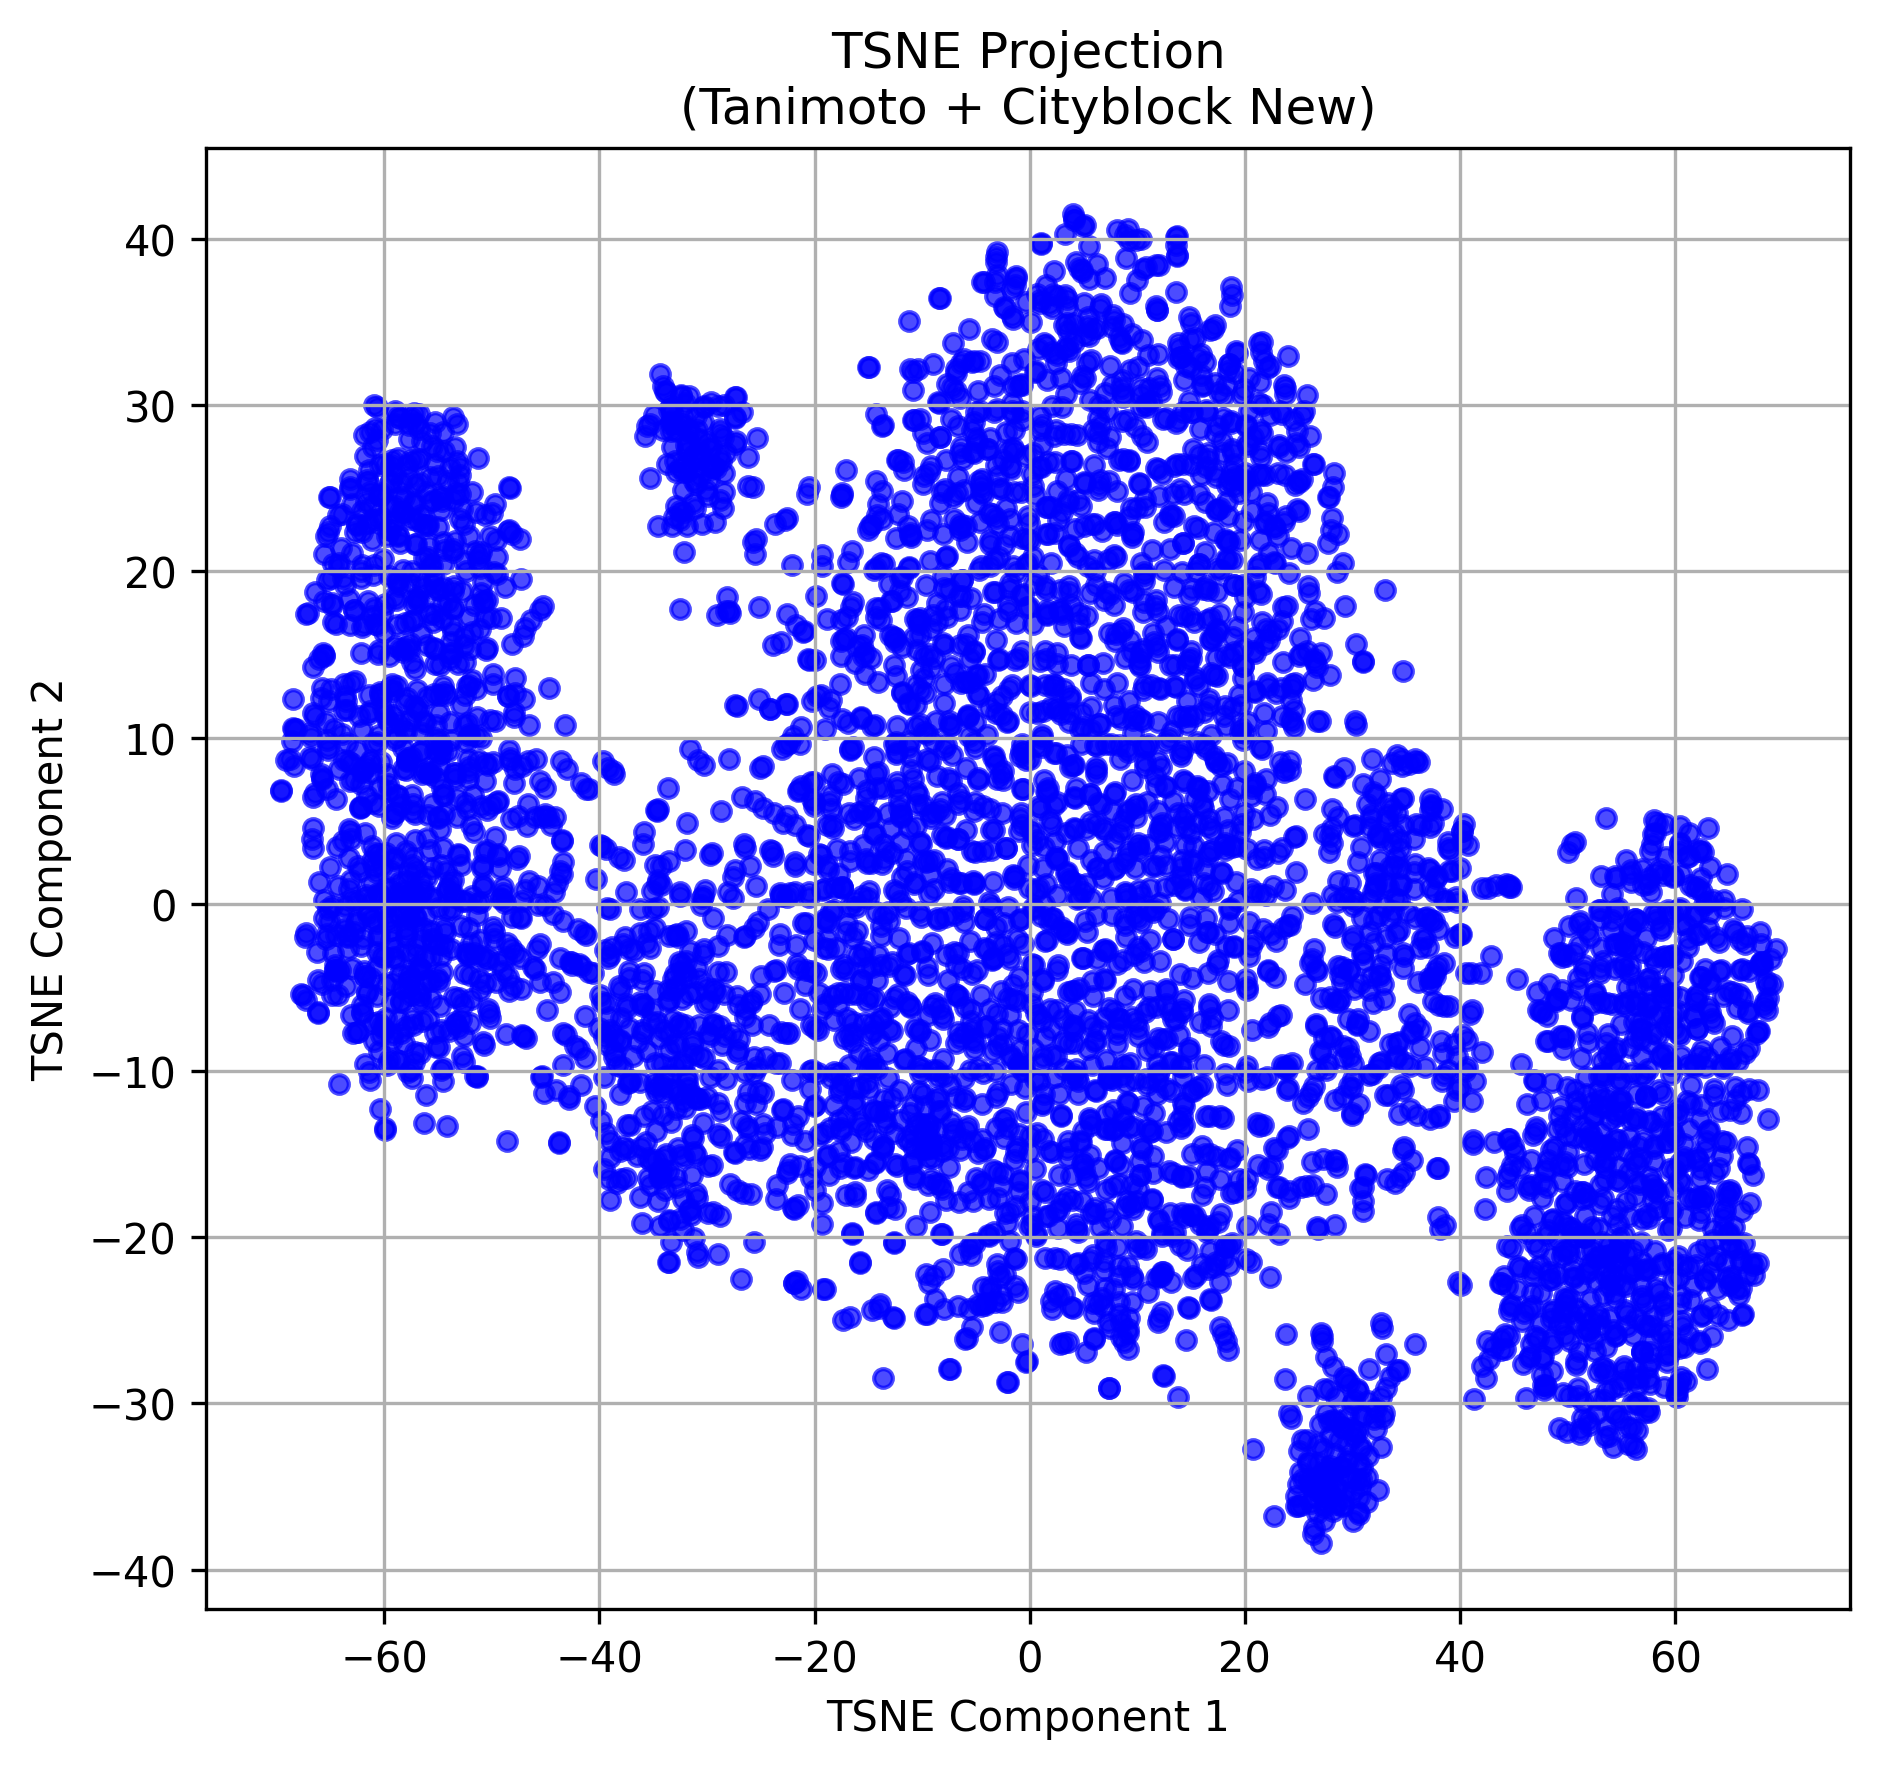

In [ ]:
import matplotlib.pyplot as plt

# -------------------------
# TSNE Projections for New Custom Distance Matrices
# -------------------------

# TSNE Projection for the "Hamming + Cityblock New" Distance Matrix
tsne_hamming_new = TSNE(metric='precomputed', random_state=42, init='random', 
                        perplexity=45.0, learning_rate=200)
Y_hamming_new = tsne_hamming_new.fit_transform(hamming_dist_matrix_new)

# TSNE Projection for the "Tanimoto + Cityblock New" Distance Matrix
tsne_tanimoto_new = TSNE(metric='precomputed', random_state=42, init='random', 
                         perplexity=45.0, learning_rate=200)
Y_tanimoto_new = tsne_tanimoto_new.fit_transform(tanimoto_dist_matrix_new)

#print("\nTSNE Projection for Hamming + Cityblock New computed.")
print("TSNE Projection for Tanimoto + Cityblock New computed.")


# Plot TSNE Projection for "Hamming + Cityblock New"
plt.figure(figsize=(12, 6), dpi=300)
''''
plt.subplot(1, 2, 1)
plt.scatter(Y_hamming_new[:, 0], Y_hamming_new[:, 1], 
            c='green', alpha=0.7, s=20)
plt.title("TSNE Projection\n(Hamming + Cityblock New)", fontsize=12)
plt.xlabel("TSNE Component 1", fontsize=10)
plt.ylabel("TSNE Component 2", fontsize=10)
plt.grid(True)
'''
# Plot TSNE Projection for "Tanimoto + Cityblock New"
plt.subplot(1, 2, 2)
plt.scatter(Y_tanimoto_new[:, 0], Y_tanimoto_new[:, 1], 
            c='blue', alpha=0.7, s=20)
plt.title("TSNE Projection\n(Tanimoto + Cityblock New)", fontsize=12)
plt.xlabel("TSNE Component 1", fontsize=10)
plt.ylabel("TSNE Component 2", fontsize=10)
plt.grid(True)

plt.tight_layout()
plt.show()

# Clustering with K-Medoids Using Multiple Distance Metrics

In this section, we perform clustering using the K-Medoids algorithm across a range of cluster values and various distance metrics. The goal is to evaluate how different metrics affect the clustering results and to determine the optimal number of clusters for our dataset.

---

## What This Section Does

1. **Define Cluster Range:**
   - We set a list of cluster numbers (`k_values`) ranging from 2 to 10 to explore different segmentation granularities.

2. **Prepare Data Structures:**
   - A dictionary `cluster_results` is created to store clustering labels for each distance metric.
   - A dictionary `distance_matrices` maps descriptive names (e.g., "Gower", "Euclidean", "Hamming + Cityblock", etc.) to their corresponding precomputed distance matrices.

3. **Run K-Medoids Clustering:**
   - For each distance metric, and for each value of *k*, we run K-Medoids clustering using the precomputed distance matrix.
   - We use parameters such as:
     - `metric='precomputed'` since our distance matrices are precomputed.
     - `init='k-medoids++'` for smart initialization.
     - A fixed `random_state` for reproducibility.
     - A maximum iteration limit (`max_iter=300`).
   - The resulting cluster labels are stored in the `cluster_results` dictionary.

4. **Output:**
   - After clustering, we print a message confirming that clustering has been completed for all distance metrics.

This step sets the stage for further evaluation of clustering performance and the development of client personas based on the clustering results.

In [ ]:
from sklearn_extra.cluster import KMedoids

# Define number of clusters
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Store clustering results for different distance metrics
cluster_results = {
    "Gower": {},
    "Euclidean": {},
    "Manhattan": {},
    "Cosine": {},
    "Chebyshev": {},
    "Hamming + Cityblock": {},
    "Tanimoto + Cityblock": {},
    "Hamming + Cityblock new": {},
    "Tanimoto + Cityblock new": {},
    "Euclidean + Jaccard Distance New": {},
    "Mahalanobis + Hamming Distance New": {}
}

# List of distance matrices (including the new custom distances)
distance_matrices = {
    "Gower": gower_distances,
    "Euclidean": euclidean_distances,
    "Manhattan": manhattan_distances,
    "Cosine": cosine_distances,
    "Chebyshev": chebyshev_distances,
    "Hamming + Cityblock": hammingCityblock_distance,
    "Tanimoto + Cityblock": tanimotoCityblock_distance,
    "Hamming + Cityblock new": hamming_dist_matrix_new,
    "Tanimoto + Cityblock new": tanimoto_dist_matrix_new,
    "Euclidean + Jaccard Distance New": euclidean_jaccard_dist_matrix_new,
    "Mahalanobis + Hamming Distance New": mahalanobis_hamming_dist_matrix_new
}

for metric, dist_matrix in distance_matrices.items():
    print(f"\n🔹 Running K-Medoids for {metric} Distance\n")
    for k in k_values:
        print(f'Clustering with k={k}...')

        # Run K-Medoids using precomputed distance matrices
        kmedoids = KMedoids(n_clusters=k, metric='precomputed', random_state=42, init='k-medoids++', max_iter=300)
        labels = kmedoids.fit_predict(dist_matrix)

        # Store clustering results
        cluster_results[metric][k] = labels

print("✅ Clustering Completed for All Distance Metrics")


🔹 Running K-Medoids for Gower Distance

Clustering with k=2...
Clustering with k=3...
Clustering with k=4...
Clustering with k=5...
Clustering with k=6...
Clustering with k=7...
Clustering with k=8...
Clustering with k=9...
Clustering with k=10...

🔹 Running K-Medoids for Euclidean Distance

Clustering with k=2...
Clustering with k=3...
Clustering with k=4...
Clustering with k=5...
Clustering with k=6...
Clustering with k=7...
Clustering with k=8...
Clustering with k=9...
Clustering with k=10...

🔹 Running K-Medoids for Manhattan Distance

Clustering with k=2...
Clustering with k=3...
Clustering with k=4...
Clustering with k=5...
Clustering with k=6...
Clustering with k=7...
Clustering with k=8...
Clustering with k=9...
Clustering with k=10...

🔹 Running K-Medoids for Cosine Distance

Clustering with k=2...
Clustering with k=3...
Clustering with k=4...
Clustering with k=5...
Clustering with k=6...
Clustering with k=7...
Clustering with k=8...
Clustering with k=9...
Clustering with k=1

# Clustering Evaluation Metrics

In this section, we evaluate the performance of our clustering results obtained using various distance metrics and different numbers of clusters. Our goal is to determine which configuration yields the best separation and compactness of clusters. 

## Metrics Computed
- **Calinski-Harabasz Score (CH):**  
  Measures cluster separation; a higher score indicates better-defined clusters.
  
- **Davies-Bouldin Score (DB):**  
  Measures cluster compactness; a lower score is preferable.
  
- **Silhouette Score:**  
  Evaluates how similar an object is to its own cluster compared to other clusters; higher values are better.
  
- **Dunn Index:**  
  Calculates the ratio of the smallest inter-cluster distance to the largest intra-cluster distance; higher values indicate well-separated clusters.
  
- **Within-Cluster Sum of Squares (WCSS):**  
  Measures the compactness of clusters; lower values suggest tighter clusters.

## What the Code Does
1. **Helper Functions:**
   - **`dunn_index`**: Computes the Dunn Index by calculating maximum intra-cluster distances and minimum inter-cluster distances.
   - **`compute_wcss`**: Computes the Within-Cluster Sum of Squares (WCSS) for each clustering configuration.

2. **Evaluation Function (`evaluate_clustering`):**
   - Iterates through a set of predefined distance metrics.
   - For each metric, it loops through various cluster counts (k-values).
   - Computes the above evaluation metrics for each configuration.
   - Plots the metrics against the number of clusters to visualize performance.
   - Identifies and prints the optimal number of clusters for each metric.
   
3. **Output:**
   - Displays plots comparing the performance of different clustering configurations.
   - Prints the optimal k values based on each evaluation metric.
   - Returns a dictionary containing all the evaluation scores for further analysis.

This evaluation framework provides a robust means to compare clustering performance across different distance metrics and helps in selecting the most suitable clustering configuration for our financial services segmentation.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from scipy.spatial.distance import pdist

# Compute Dunn Index
def dunn_index(dist_matrix, labels):
    unique_clusters = np.unique(labels)
    intra_dists = []
    inter_dists = []

    for cluster in unique_clusters:
        cluster_points = np.where(labels == cluster)[0]
        other_points = np.where(labels != cluster)[0]
        intra_dists.append(np.max(dist_matrix[np.ix_(cluster_points, cluster_points)]))
        inter_dists.append(np.min(dist_matrix[np.ix_(cluster_points, other_points)]))

    return np.min(inter_dists) / np.max(intra_dists)

# Compute WCSS (Within-Cluster Sum of Squares)
def compute_wcss(X, labels):
    unique_clusters = np.unique(labels)
    wcss = sum([
        np.nansum((X[labels == cluster] - np.nanmean(X[labels == cluster], axis=0)) ** 2)
        for cluster in unique_clusters
    ])
    return wcss

# Evaluate clustering for all distance metrics
def evaluate_clustering(X, cluster_results, distance_matrices):
    # Updated metrics list to include new custom distances
    metrics = [
        "Gower", "Euclidean", "Manhattan", "Cosine", "Chebyshev",
        #"Hamming + Cityblock", "Tanimoto + Cityblock",
        "Hamming + Cityblock new", "Tanimoto + Cityblock new",
        "Euclidean + Jaccard Distance New", "Mahalanobis + Hamming Distance New"
    ]

    # Initialize scores dictionary for each metric
    scores = {metric: {"CH": [], "DB": [], "Silhouette": [], "Dunn": [], "WCSS": []} for metric in metrics}

    for metric in metrics:
        print(f"\n🔹 Evaluating Clustering Performance for {metric} Distance")
        # Retrieve the k-values from the clustering results for this metric
        current_k_values = sorted(cluster_results[metric].keys())
        for k in current_k_values:
            labels = cluster_results[metric][k]
            distance_matrix = distance_matrices[metric]

            try:
                # Evaluate clustering metrics using the original data matrix X
                scores[metric]["CH"].append(calinski_harabasz_score(X, labels))
                scores[metric]["DB"].append(davies_bouldin_score(X, labels))
                scores[metric]["Silhouette"].append(silhouette_score(distance_matrix, labels, metric='precomputed'))
                scores[metric]["Dunn"].append(dunn_index(distance_matrix, labels))
                scores[metric]["WCSS"].append(compute_wcss(X, labels))
            except ValueError as e:
                print(f"⚠️ Skipping k={k} for {metric} due to an error: {e}")
                scores[metric]["CH"].append(np.nan)
                scores[metric]["DB"].append(np.nan)
                scores[metric]["Silhouette"].append(np.nan)
                scores[metric]["Dunn"].append(np.nan)
                scores[metric]["WCSS"].append(np.nan)

    # Plot metrics for comparison with high resolution (300 dpi)
    fig, axes = plt.subplots(5, 1, figsize=(18, 30), dpi=300)
    metric_details = [
        ("Calinski-Harabasz Score (Higher is better) - Cluster Separation", "CH"),
        ("Davies-Bouldin Score (Lower is better) - Cluster Compactness", "DB"),
        ("Silhouette Score (Higher is better) - Cluster Cohesion", "Silhouette"),
        ("Dunn Index (Higher is better) - Cluster Separation", "Dunn"),
        ("WCSS (Lower is better) - Cluster Compactness", "WCSS")
    ]

    for idx, (title, score_key) in enumerate(metric_details):
        for metric in metrics:
            current_k_values = sorted(cluster_results[metric].keys())
            valid_scores = np.array(scores[metric][score_key])
            valid_k_values = np.array(current_k_values)[~np.isnan(valid_scores)]
            valid_scores = valid_scores[~np.isnan(valid_scores)]
            axes[idx].plot(valid_k_values, valid_scores, marker='o', linestyle='--', label=metric)
        axes[idx].set_title(title)
        axes[idx].set_xlabel("Number of Clusters (k)")
        axes[idx].grid(True)
        axes[idx].legend(loc='best', fontsize=10)

    plt.show()

    # Print the best k for each metric
    for metric in metrics:
        current_k_values = sorted(cluster_results[metric].keys())
        ch_scores = np.array(scores[metric]['CH'])
        db_scores = np.array(scores[metric]['DB'])
        silhouette_scores = np.array(scores[metric]['Silhouette'])
        dunn_scores = np.array(scores[metric]['Dunn'])
        wcss_scores = np.array(scores[metric]['WCSS'])
        print(f"\n🔹 Best k values for {metric} Distance:")
        print(f"✅ Optimal k (CH - Separation): {current_k_values[np.argmax(ch_scores)]}")
        print(f"✅ Optimal k (DB - Compactness): {current_k_values[np.argmin(db_scores)]}")
        print(f"✅ Optimal k (Silhouette - Cohesion): {current_k_values[np.argmax(silhouette_scores)]}")
        print(f"✅ Optimal k (Dunn - Separation): {current_k_values[np.argmax(dunn_scores)]}")
        print(f"✅ Optimal k (WCSS - Compactness, Elbow Expected): {current_k_values[np.argmin(wcss_scores)]}")

    return scores

# Example call (ensure that X corresponds to the data on which you want to evaluate clustering)
clustering_scores = evaluate_clustering(df, cluster_results, distance_matrices)


🔹 Evaluating Clustering Performance for Gower Distance

🔹 Evaluating Clustering Performance for Euclidean Distance

🔹 Evaluating Clustering Performance for Manhattan Distance

🔹 Evaluating Clustering Performance for Cosine Distance

🔹 Evaluating Clustering Performance for Chebyshev Distance

🔹 Evaluating Clustering Performance for Hamming + Cityblock new Distance

🔹 Evaluating Clustering Performance for Tanimoto + Cityblock new Distance


# 3D t-SNE Cluster Visualization

In this section, we project our precomputed distance matrix into 3D space using t-SNE and visualize the results with an interactive Plotly scatter plot. This helps us explore the structure of our clusters and understand their relationships.

## What This Section Does

1. **Configuration & Preprocessing:**
   - **Distance Metric:** We use the "Tanimoto + Cityblock new" distance matrix.
   - **Cluster Selection:** We select 3 clusters (ensure these labels exist in the clustering results).
   - **t-SNE Settings:** We set `perplexity` to 45 to balance local and global data structure during dimensionality reduction.
   - **Data Validation:** We check that the distance matrix is valid (i.e., square with no NaN or Inf values).

2. **t-SNE Projection:**
   - Applies t-SNE with precomputed distances to reduce the data to 3 dimensions.
   - Stores the 3D coordinates for visualization.

3. **Visualization:**
   - Creates a DataFrame with t-SNE coordinates and cluster labels.
   - Generates an interactive 3D scatter plot using Plotly.
   - Uses the "Cividis" colorscale to color points based on their cluster assignments.
   - Customizes the layout (axis titles, aspect ratio, and figure size) for clear visualization.

This interactive 3D visualization provides insights into the spatial distribution of clusters, enabling a deeper understanding of the underlying structure of our client segmentation.

In [ ]:
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Set distance metric, num of clusters and perplexity
distance_metric = "Tanimoto + Cityblock new"
num_clusters = 3
perplexity_value = 45

dist_matrix = distance_matrices[distance_metric]

# Check if the distance matrix is valid
if np.isnan(dist_matrix).any() or np.isinf(dist_matrix).any():
    raise ValueError(f"⚠️ {distance_metric} distance matrix contains NaN or Inf values. Check your preprocessing!")

if dist_matrix.shape[0] != dist_matrix.shape[1]:
    raise ValueError(f"⚠️ {distance_metric} distance matrix must be square (NxN).")

# Check if the selected number of clusters exists
if num_clusters not in cluster_results[distance_metric]:
    raise ValueError(f"⚠️ num_clusters={num_clusters} is not in cluster_results[{distance_metric}]. Check clustering output!")

labels = cluster_results[distance_metric][num_clusters]

# Compute 3D t-SNE projection
tsne = TSNE(n_components=3, metric='precomputed', init='random', random_state=42, perplexity=perplexity_value)
X_tsne_3d = tsne.fit_transform(dist_matrix)

# Create DataFrame for visualization
df_plot = pd.DataFrame({'x': X_tsne_3d[:, 0], 'y': X_tsne_3d[:, 1], 'z': X_tsne_3d[:, 2], 'Cluster': labels})

# Generate interactive 3D scatter plot
fig = go.Figure(data=[
    go.Scatter3d(
        x=df_plot['x'],
        y=df_plot['y'],
        z=df_plot['z'],
        mode='markers',
        marker=dict(
            size=5,  # Explicitly setting the size
            color=df_plot['Cluster'],  # Color by cluster
            colorscale='Cividis',  # Set color scale
            #colorscale='Turbo',  # Set color scale
            #colorscale='Portland',  # Set color scale
            opacity=0.8  # Adjust transparency
        )
    )
])

# Customize layout
fig.update_layout(
    title=f"3D t-SNE Cluster Visualization ({distance_metric} Distance, k={num_clusters})",
    scene=dict(
        xaxis_title="t-SNE 1",
        yaxis_title="t-SNE 2",
        zaxis_title="t-SNE 3",
        aspectmode="cube"  # Keeps the aspect ratio balanced
    ),
    margin=dict(l=0, r=0, b=0, t=50),
    width=1500,  # Adjusted figure width
    height=1000   # Adjusted figure height
)

fig.show()

# Reconstructing Cluster Characteristics

In this section, we reconstruct the cluster summaries in the original feature space. Our goal is to obtain an interpretable summary for each cluster that reflects the original scales of the numerical variables and the original categorical labels.

## Steps Overview

1. **Feature Name Reconstruction:**
   - Retrieve the column names from the OneHotEncoder for the categorical variables.
   - Generate names for the PCA-transformed numerical features.
   - Combine these names and adjust if there is any mismatch with the number of columns in the preprocessed data.

2. **Cluster Summary Creation:**
   - Convert the preprocessed data back into a DataFrame with proper column labels.
   - Append the cluster labels (obtained from clustering) and compute the mean of each feature per cluster.

3. **Inverse Transformation of Numerical Features:**
   - Use the saved PCA object (`pca_obj`) and scaler (`scaler_num`) to transform the PCA components back to the original (winsorized and scaled) numerical features.
   - Reconstruct a DataFrame of the original numerical features using the column names from the reduced dataset.
   - Replace the PCA components with these original numerical values and optionally clip unrealistic values (e.g., ensuring Age is between 18 and 100).

4. **Decoding of Categorical Features:**
   - For each categorical variable, determine the representative category by selecting the one-hot encoded column with the highest mean value (i.e., the column with the maximum average for that cluster).
   - Extract and add the original categorical labels back into the summary.

5. **Display the Final Cluster Summary:**
   - The final DataFrame displays the cluster means in their original scale, along with the decoded categorical values, providing an interpretable view of cluster characteristics.

This reconstructed cluster summary will serve as the basis for further persona development and targeted financial service strategies.

In [ ]:
import pandas as pd
from IPython.display import display
import numpy as np

# Ensure OneHotEncoder is fitted before retrieving feature names
if not hasattr(encoder, 'get_feature_names_out'):
    raise ValueError("⚠️ Encoder is not fitted. Ensure OneHotEncoder is properly trained before extracting feature names.")

# Get the actual feature names from OneHotEncoder (using the original categorical columns)
encoded_feature_names = encoder.get_feature_names_out(input_features=categorical_columns)
# Names for PCA-transformed numerical features
numerical_feature_names = [f'PCA_{i+1}' for i in range(X_pca.shape[1])]
all_feature_names = numerical_feature_names + list(encoded_feature_names)

# Auto-adjust feature name list if mismatched
if len(all_feature_names) != X_preprocessed.shape[1]:
    print(f"⚠️ Adjusting feature names dynamically: {len(all_feature_names)} names vs {X_preprocessed.shape[1]} columns.")
    all_feature_names = all_feature_names[:X_preprocessed.shape[1]]

# Convert preprocessed data back to DataFrame with proper labels
cluster_summary = pd.DataFrame(X_preprocessed, columns=all_feature_names)
cluster_summary['Cluster'] = labels

# Compute the mean of each feature per cluster
summary = cluster_summary.groupby('Cluster').mean()

# Make a copy for original scale reconstruction
summary_original_scale = summary.copy()

# Inverse transform numerical features:
# First, invert PCA (from PCA space back to scaled numerical space),
# then invert scaling (from scaled space back to original numerical values).
# (Assumes scaler_num and pca_obj are your fitted StandardScaler and PCA objects, 
#  and that numerical_features_reduced.columns contains the original numerical feature names.)
if len(numerical_feature_names) == X_pca.shape[1]:
    try:
        # Inverse PCA transformation
        inv_scaled = pca_obj.inverse_transform(summary[numerical_feature_names])
        # Inverse scaling transformation
        original_numerical = scaler_num.inverse_transform(inv_scaled)
        # Create a DataFrame with the original numerical feature names
        original_numerical_df = pd.DataFrame(original_numerical, index=summary.index, columns=numerical_features_reduced.columns)
        # Remove the PCA component columns and add the original numerical columns
        summary_original_scale.drop(columns=numerical_feature_names, inplace=True, errors='ignore')
        summary_original_scale = pd.concat([summary_original_scale, original_numerical_df], axis=1)
        # Optionally clip unrealistic values (for example, if 'Age' is one of the features)
        if 'Age' in summary_original_scale.columns:
            summary_original_scale['Age'] = summary_original_scale['Age'].clip(lower=18, upper=100)
    except ValueError as e:
        print(f"⚠️ Error in inverse transformation: {e}. Skipping numerical rescaling.")

# Decode categorical features:
# For each categorical variable, select the dummy column with the highest mean value,
# and then extract the original category name.
try:
    categorical_decoded = pd.DataFrame(index=summary.index, columns=categorical_columns)
    for feature in categorical_columns:
        # Get columns corresponding to this feature (expected format: feature_category)
        feature_cols = [col for col in encoded_feature_names if col.startswith(feature + '_')]
        # For each cluster, select the category with the highest average value
        categorical_decoded[feature] = summary[feature_cols].idxmax(axis=1).str.replace(feature + '_', '')
    # Add the decoded categorical columns to the reconstructed DataFrame
    summary_original_scale = pd.concat([summary_original_scale, categorical_decoded], axis=1)
    # Optionally, drop the original one-hot encoded columns if present
    summary_original_scale.drop(columns=list(encoded_feature_names), inplace=True, errors='ignore')
except Exception as e:
    print(f"⚠️ Error decoding categorical values: {e}")

# Display the reconstructed cluster characteristics
print("🔹 Cluster Characteristics (Original Scale with Categorical Labels Restored):")
display(summary_original_scale)



🔹 Cluster Characteristics (Original Scale with Categorical Labels Restored):


,Age,FamilySize,Income,Wealth,Debt,FinEdu,ESG,Digital,BankFriend,LifeStyle,Luxury,Saving,Gender,Job,Area,CitySize,Investments
Cluster,,,,,,,,,,,,,,,,,
0,49.696160,2.031355,0.747145,0.755065,0.542698,0.679773,0.675429,0.731500,0.711213,0.678145,0.713671,0.589398,1,2,1,3,3
1,80.419457,2.088357,0.411826,0.430630,0.180784,0.359823,0.603597,0.337615,0.624985,0.283772,0.281669,0.361550,1,5,1,2,2
2,56.366155,3.027729,0.553438,0.544951,0.493858,0.482804,0.518489,0.497611,0.553389,0.417725,0.423234,0.565907,0,2,1,2,3


# Persona Insights & Service Models

This section summarizes our persona analysis based on the clustering results. We have identified three distinct clusters and developed target personas to guide our financial service strategies.

---

## Cluster 0: **Urban High-Earner**

### **Persona Overview**
- **Age:** Around 49 years old  
- **Gender:** Predominantly male  
- **Job:** Mostly employees/workers (Job code 2)  
- **Location:** Large city (CitySize = 3), Nord region (Area = 1)  
- **Family Size:** ~2 (often small families or couples)  

### **Financial Profile**
- **Income & Wealth:** High (top ~20-25th percentile)  
- **Debt:** Moderate (~0.56)  
- **Financial Education:** Strong (~0.72)  
- **Digital Adoption:** High (~0.76)  
- **Bank Friendliness:** High (~0.74)  
- **Investments:** Prefers capital accumulation (Investments = 3)  

### **Key Traits**
- **Lifestyle & Luxury:** Above-average spending (Lifestyle ~0.70, Luxury ~0.75). They enjoy premium products and experiences.
- **Saving Behavior:** Moderate saving propensity (~0.60).
- **ESG Orientation:** Fairly high (~0.69), indicating openness to socially responsible or sustainable investing.

### **Service Model**
- **Primary Channel:** Digital or Hybrid  
  - Comfortable with digital tools, online banking, and self-service platforms.  
  - Also value expert advice via video calls or in-branch appointments for complex products.

### **Financial Needs**
1. **Advanced Wealth Management & Investment Advice**  
   - Portfolio diversification including equities, funds, and sustainable/ESG investing.  
   - Capital-accumulation products to grow wealth.
2. **Premium Banking Services**  
   - High-limit credit cards, loyalty programs, and travel perks.
3. **Retirement & Insurance Planning**  
   - Retirement solutions as they near 50.
4. **Lifestyle & Legacy Services**  
   - Concierge services, personal finance management tools, and estate planning.

---

## Cluster 1: **Retired Traditionalists**

### **Persona Overview**
- **Age:** ~78 years old  
- **Gender:** Predominantly female  
- **Job:** Mostly retired (Job code 5)  
- **Location:** Medium-sized city (CitySize = 2), Nord region (Area = 1)  
- **Family Size:** ~2.35 (small to mid-sized households)

### **Financial Profile**
- **Income & Wealth:** Lower (around the 40th percentile)  
- **Debt:** Very low (~0.22)  
- **Financial Education:** Lower (~0.37)  
- **Digital Adoption:** Low (~0.34)  
- **Bank Friendliness:** Moderate (~0.61)  
- **Investments:** Prefers lump-sum investments (Investments = 2)

### **Key Traits**
- **Lifestyle & Luxury:** Low spending (both ~0.28).  
- **Saving Behavior:** Low saving propensity (~0.39).  
- **ESG Orientation:** Moderate (~0.58); not actively seeking sustainable options.

### **Service Model**
- **Primary Channel:** Physical/Call Center  
  - Low digital adoption calls for in-branch or phone-based support.  
  - Benefit from dedicated relationship managers who offer personalized assistance.

### **Financial Needs**
1. **Retirement Income & Long-Term Care**  
   - Annuities, pension optimization, and home-care financing.
2. **Estate & Inheritance Planning**  
   - Wills, trusts, and end-of-life expenses.
3. **Simplified Insurance Products**  
   - Health insurance, funeral coverage, and final expense insurance.
4. **Assisted Banking**  
   - Simplified or assisted digital solutions, with robust phone/branch support for day-to-day transactions.

---

## Cluster 2: **Midlife Moderates**

### **Persona Overview**
- **Age:** ~55 years old  
- **Gender:** Predominantly female  
- **Job:** Mostly employees/workers (Job code 2)  
- **Location:** Medium-sized city (CitySize = 2), Nord region (Area = 1)  
- **Family Size:** ~2.79 (slightly larger families)

### **Financial Profile**
- **Income & Wealth:** Moderate (around the 55-60th percentile)  
- **Debt:** Moderate (~0.50)  
- **Financial Education:** Average (~0.49)  
- **Digital Adoption:** Moderate (~0.53)  
- **Bank Friendliness:** Medium (~0.56)  
- **Investments:** Prefers capital accumulation (Investments = 3)

### **Key Traits**
- **Lifestyle & Luxury:** Moderate discretionary spending (~0.46 for both).  
- **Saving Behavior:** Moderately inclined to save (~0.56).  
- **ESG Orientation:** Moderate (~0.54); receptive but not strongly driven by sustainability factors.

### **Service Model**
- **Primary Channel:** Hybrid  
  - Comfortable with digital tools for everyday transactions.  
  - May prefer in-person advice for more complex financial decisions.

### **Financial Needs**
1. **Retirement & Midlife Planning**  
   - Pension top-ups, bridging strategies, and supplementary savings as they are 10-15 years from retirement.
2. **Family/Home Protection**  
   - Insurance for family, mortgage protection, property, or educational planning for children.
3. **Investment Growth**  
   - Balanced portfolios that combine capital accumulation with moderate risk.
4. **Health & Life Insurance**  
   - Exploration of health insurance, critical illness coverage, or life insurance options.

---

These detailed personas can be used to tailor our marketing strategies, product development, and service models to effectively target and serve each client segment.